In [215]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_model"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

[about matplotlib](https://jrc-park.tistory.com/274)

# 선형 회귀

In [216]:
import numpy as np

X = 2 * np.random.rand(100 ,1) # 0 ~ 1 균일 분포 표준정규분포 난수
y = 4 + 3 * X + np.random.randn(100, 1) # 평균 0, 표준편차 1의 가우시안 표준정규분포 난수

그림 저장: generated_data_plot


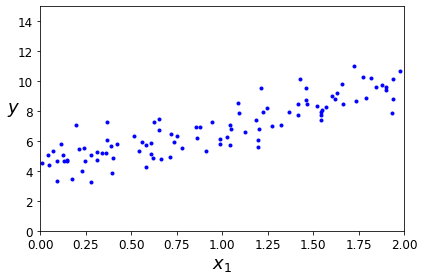

In [217]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18) # rotation : 'y' 표현
plt.axis([0, 2, 0, 15])
save_fig('generated_data_plot')
plt.show()

### 정규 방정식

$\theta^2=(X^TX)^−1X^Ty$

In [218]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

In [219]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

그림 저장: linear_model_predictions_plot


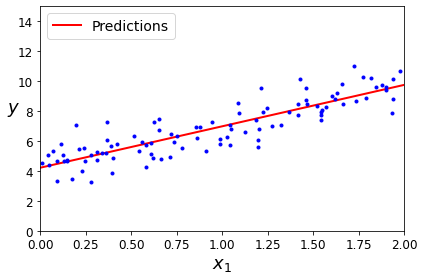

In [220]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [221]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

$\hat{y}=X\hat{\theta}$

In [222]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

`Linear Regression` 클래스는 `scipy.linalg.lstsq()` 을 기반으로 함. 함수 직접 사용 가능

In [223]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

이 함수는 $\hat{\theta} = X^+y$ 계산. $X^+$는 유사역행렬

In [224]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 경사 하강법
### 배치 경사 하강법 (batch gradient descent)

**그레이디언트 벡터** <br><br>
$\nabla_\theta MSE(\theta)=\frac{2}{m}X^T(X^\theta−y)$ <br><br>
**경사 하강법 스텝** <br><br>
$\theta^{(next step)} = \theta - \nabla_\theta MSE(\theta)$

In [225]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients
theta

array([[4.21509616],
       [2.77011339]])

In [226]:
print(X_new)
print(X_new_b)
print(X_new_b.dot(theta))

[[0]
 [2]]
[[1. 0.]
 [1. 2.]]
[[4.21509616]
 [9.75532293]]


In [227]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients # -= 로 할 경우 ??
        if theta_path is not None:
            theta_path_bgd.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title("$\eta = {}$".format(eta), fontsize=18)

그림 저장: gradient_descent_plot


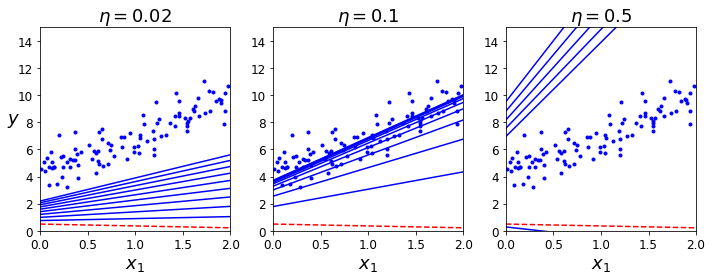

In [228]:
np.random.seed(42)
theta = np.random.randn(2,1)

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, 0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, 0.1, theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, 0.5)

save_fig("gradient_descent_plot")
plt.show()

### 확률적 경사 하강법 (stochastic gradient descent)
- 매 스텝에서 한 개의 샘플을 무작위 선택, 그 샘플에 대한 gradient 계산
- 확룰적(무작위)이므로 불안정, 최솟값 다다를 때까지 요동치며 감소
- 불규칙 -> 지역 최솟값 건너뛰고 전역 최솟값 찾을 가능성 높음 But, 전역 최솟값에 다다르지 못하게 할 수도 있음
- 이를 해결 위해 **학습률을 점진적으로 감소**
- (금속 공학 분야의 담금질 기법 알고리즘과 유사)

In [229]:
theta_path_sgd = []
m = len(X_b)

일반적으로 한 반복에서 m번 되풀이하고, 이 때 각 반복을 **에포크(epoch)** 라고 함

그림 저장: sgd_plot


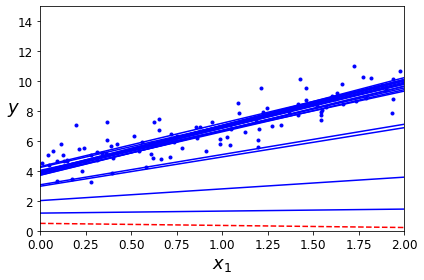

In [230]:
np.random.seed(42)
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

In [231]:
theta

array([[4.21076011],
       [2.74856079]])

In [232]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel()) # ravel() : 다차원 배열을 1차원 배열로 풀어줌

SGDRegressor(eta0=0.1, penalty=None)

- 최대 1000번 에포크
- 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 (tol=1e-3)
- 학습률 0.1로 기본 학습 스케줄 (eta-0.1)
- SGDRegressor 의 `fit` 은 `y`로 1d array을 요구함

In [233]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.23868557]), array([2.82181634]))

### 미니배치 경사 하강법 (mini-batch gradient descent)
- 각 스텝에서 전체 훈련 세트나 하나의 샘플이 아닌 **미니배치**라 부르는 임의의 작은 샘플에 대해 gradient 계산
- 장점 : 행렬 연산에 최적화된 하드웨어, GPU를 사용해서 얻는 성능 향상
- SGD에 비해 덜 불규칙함

In [234]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2, 1)
t0, t1 = 200, 1000

def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
theta

array([[4.25214635],
       [2.7896408 ]])

[- vs -= operatios with numpy](https://stackoverflow.com/questions/9047111/vs-operators-with-numpy)

In [235]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)
theta_path_bgd[:, 0][0], theta_path_bgd[:, [0]][0]

(array([1.78737583]), array([[1.78737583]]))

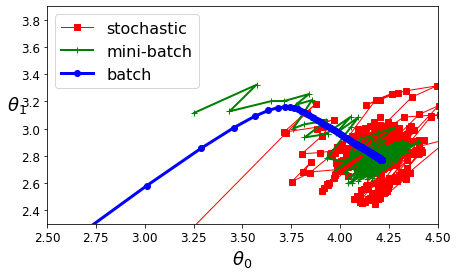

In [236]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="batch")
plt.legend(loc="upper left", fontsize=16) # r'' -> raw string
plt.xlabel(r"$\theta_0$", fontsize=18)
plt.ylabel(r"$\theta_1$", rotation=0, fontsize=18)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

[`np.array[:,0]` vs `np.array[:,[0]]`](https://stackoverflow.com/questions/48858377/whats-the-difference-between-np-array-0-and-np-array-0)

## 다항 회귀

In [237]:
import numpy as np
import numpy.random as nrd

In [238]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

그림 저장: quadratic_data_plot


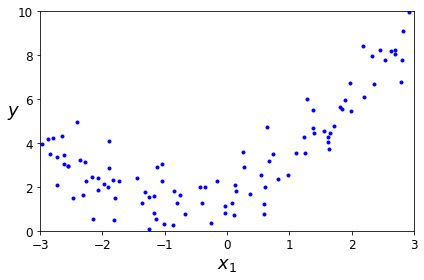

In [239]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [240]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

**PolynomialFeatures** : degree의 기본값은 2, include_bias의 기본값은 True (편향을 위한 특성($x_0$)인 1이 추가)

In [241]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

그림 저장: quadratic_predictions_plot


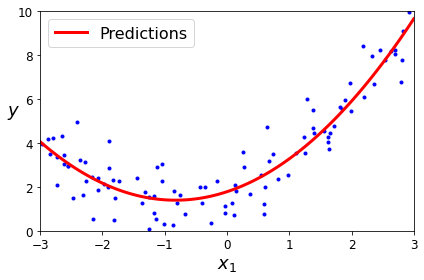

In [242]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new) # fit_transform 해도 상관 없나?  -> X
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=3, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=16)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

[`fit_transform` vs `transform`](https://khalidpark2029.tistory.com/82]) <br>
 ✔ PolynomialFeatures의 `fit`은 뭘 수행하나? -> [scikit-learn github](https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09b/sklearn/preprocessing/_polynomial.py#L270)

그림 저장: high_degree_polynomials_plot


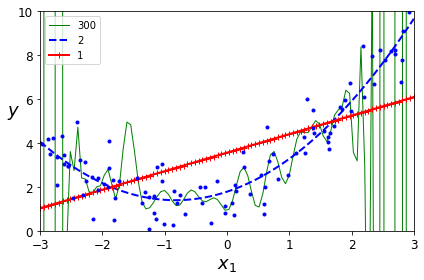

In [243]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    ss = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("ss", ss),
        ("lin_reg", lin_reg),
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

### 학습 곡선(learning curve)
- 모델이 데이터에 과대적합 or 과소적합되었는지 판단
- 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기(또는 훈련 반복)의 함수로 나타냄

In [251]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        X_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], X_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

`plt.plot(np.array)` : 배열 인덱스를 x축에 자동으로 맞추어줌

그림 저장: underfitting_learning_curves_plot


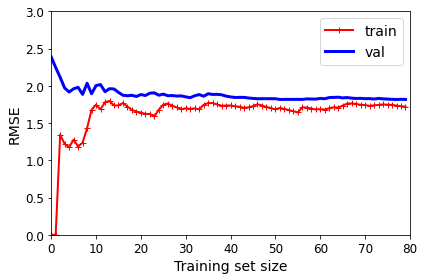

In [259]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

- 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있음 -> 과소적합 모델의 전형적 모습
- 과소적합되어 있다면 훈련샘플을 더 추가해도 효과가 없음. 복잡한 모델 사용 or 더 나은 특성 사용

그림 저장: overfitting_learning_curves_plot


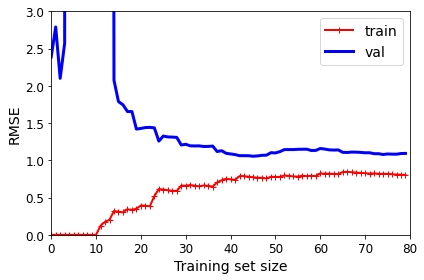

In [262]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("overfitting_learning_curves_plot")
plt.show()

- 훈련 데이터의 오차가 이전 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이의 공간 -> 검증 데이터에서보다 훈련 데이터에서의 성능이 훨씬 낫다는 뜻 -> **과대적합**
- 더 큰 훈련 세트 사용 시 두 곡선이 점점 가까워짐
- 과대적합 해결 방법 : 검증 오차가 훈련 오차에 더 근접할 때까지 더 많은 훈련 데이터 추가

## 규제가 있는 선형 모델
- 과대적합을 감소시키는 방법 (모델의 가중치를 제한)
- 릿지, 라쏘, 엘라스틱

### 릿지 회귀

$J(\theta) = MSE(\theta) + \alpha\sum_{i=1}^n\left\vert\theta_i\right\vert$

In [263]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [267]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [268]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

그림 저장: ridge_regression_plot


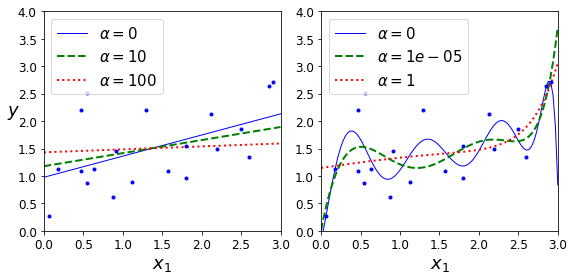

In [281]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("ss", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])
        
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()